# neurolime beta
lab meeting 2017

on threat data

Project Description: Nonlinear classification algorithms, like deep learning, are not commonly used in neuroimaging analysis because the resulting classification weights are non-interpretable. The toolbox, LIME, developed by Ribeiro, Singh, & Guestrin (2016) addresses this issue with 2D image data by generating a set of perturbed instances or “super pixels” and applying the original classifier on this new set of data. Then, using a local weighted regression technique, it determines which of the super pixels best “explain” the original classification. Our goal is to adapt this method to neuroimaging data.

Find the original lime software here: https://github.com/marcotcr/lime

In [1]:
import pickle
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import LeaveOneGroupOut, LeavePGroupsOut, GroupShuffleSplit
from sklearn.neural_network import MLPClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from nltools.data import Brain_Data
from nltools.plotting import plotBrain
np.set_printoptions(precision=2, suppress=True)

In [2]:
#Set paths
data_dir = '../Data/'

# Get brain mask path
mask_filename = os.path.join('BinaryWholeBrain.nii')

# Get subject data path
train_list=sorted(glob.glob(os.path.join(data_dir,'Auditory_Threat/Train/*con_000[1-2].img')))

# Get labels file
filename= os.path.join(data_dir,'Auditory_Threat/IE_Acq_Labels.csv')

# Step 1: Train a nonlinear classification on neuroimaging data

## Set up the training and test data files

The training data in this example comes from the Auditory Threat Acquisition Task from IE.

In [3]:
# Use Cosan tools to make things easier
dat = Brain_Data(train_list)

dat #This is now a 100 subject x 238955 voxel object in MNI space; a bit easier to work with

/Volumes/engram/Users/marianne/anaconda2/lib/python2.7/site-packages/nilearn/image/resampling.py:514: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  copy=not input_img_is_string)
/Volumes/engram/Users/marianne/anaconda2/lib/python2.7/site-packages/nilearn/masking.py:95: RuntimeWarning: invalid value encountered in divide
  / np.sum(np.isfinite(extrapolation), axis=0))
/Volumes/engram/Users/marianne/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


nltools.data.brain_data.Brain_Data(data=(136, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])

In [4]:
labels = pd.read_csv(filename) #This is a data frame with all of our labels for each of the images loaded in above
# Lets add in subject labels to each image so we correctly handle cross-validation
labels['subject_id'] = np.repeat(np.arange(1,(len(labels)/2)+1),2).astype(str)

,labels,subject_id
0,csp,1
1,csm,1
2,csp,2
3,csm,2
4,csp,3


Do a train test split, keep 90% of data in training

In [5]:
# Split the data into 90% train, 10% test respecting the fact that each subject has multiple images
gss = GroupShuffleSplit(n_splits=1,test_size=.10,random_state=0)

# Syntax is a bit weird here because we get back a generator, but the important thing are the training and testing indices
train_idx, test_idx = gss.split(dat.data,labels['labels'],labels['subject_id']).next()

# Index our data
# Brain_Data objects keep the actual voxel values in their .data attribute so create a variable to make things easier
x_train = dat.data[train_idx]
x_test = dat.data[test_idx]

# Same thing for our labels
y_train = labels.iloc[train_idx,0]
y_test = labels.iloc[test_idx,0]

## Train the classifier

random forests

In [25]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train, y_train)
# run cross-validation on training data
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, x_train, y_train, cv=5)
print("5 fold CV Scores:" )
print(scores) 
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# test on validation set
score = clf.score(x_test, y_test)
print("Validation Set Test Accuracy: ")
print(score)

5 fold CV Scores:
[ 0.69  0.54  0.71  0.62  0.54]
CV Accuracy: 0.62 (+/- 0.14)
Validation Set Test Accuracy: 
0.571428571429


In [20]:
print(clf.feature_importances_)
print(clf.predict_proba)

[ 0.  0.  0. ...,  0.  0.  0.]
<bound method RandomForestClassifier.predict_proba of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)>


# Step 2: Apply LIME

### Create the explainer object

In [49]:
# Give all our voxels names cause Lime wants that
feat_names = range(1,x_train.shape[1]+1)

# Give our class labels names too
label_names = ['novel', 'target']

# Create a tabular explainer (for continuous data) using all our voxels, but don't discretize them
explainer = LimeTabularExplainer(x_train, feature_names=feat_names, class_names=label_names, discretize_continuous=False,feature_selection='none')

### Now let's explain an instance of the test data

In [16]:
# select first instance from the holdout set
print("True Class: ")
print(y_test)
# testing on first, csp

True Class: 
4      csp
5      csm
66     csp
67     csm
72     csp
73     csm
74     csp
75     csm
76     csp
77     csm
98     csp
99     csm
104    csp
105    csm
Name: labels, dtype: object


In [26]:
# explain an instance
# set up num features
n_feat=x_train.shape[1] # numb of vox
# set up num samples
n_samp=2000 #not sure what to set this
exp = explainer.explain_instance(x_test[0], clf.predict_proba, num_features=n_feat, num_samples=n_samp, top_labels=None)
# num_features: maximum number of features present in explanation

/Volumes/engram/Users/marianne/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.03952300936e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)


In [33]:
import pickle
pickle.dump(exp,open("threat_explanation_rbfsvm_nodiscret_allvox_2000samp.p","wb"))

In [53]:
vox_explanations=np.array(exp.as_list())
vox_explanations=pd.DataFrame(vox_explanations)
vox_explanations.to_csv('threat_array_NN_nodiscret_allvox_nsamp.csv',index=False)
#odd_exp_array=np.delete(odd_exp_array,1,axis=1)
vox_explanations.columns = ['voxel_id','prob_shift']
print(vox_explanations.shape)
#vox_explanations.head()

#TO DO REMOVE THE flot from voxid

(2000, 2)


,voxel_id,prob_shift
0,69.0,0.028425
1,997.0,-0.027780
2,1493.0,0.026952
3,174.0,-0.026415
4,1183.0,0.025097


In [22]:
# Now lets put them back into brain space using the same trick as above
explainer_weight_map = dat[0].copy()
explainer_weight_map.data =  np.zeros_like(dat[0].data)

In [23]:
explainer_weight_map.data[vox_explanations['voxel_id']] = vox_explanations['prob_shift']

Plotting unthresholded image


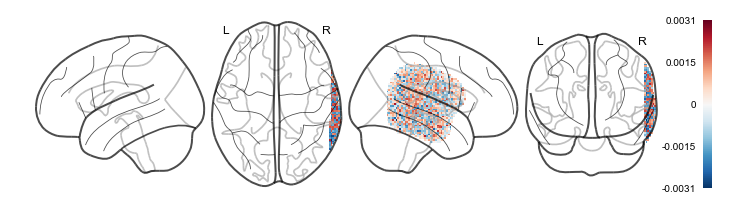

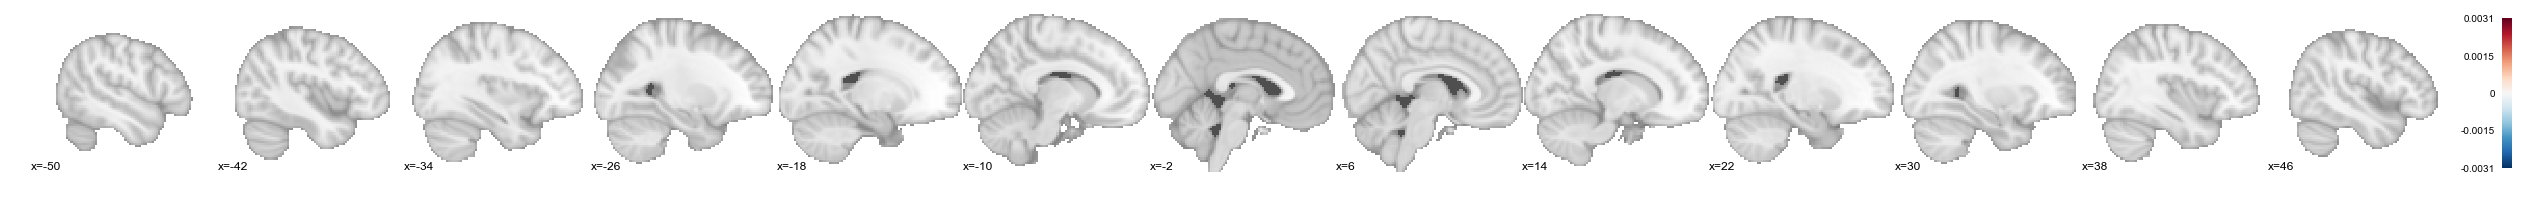

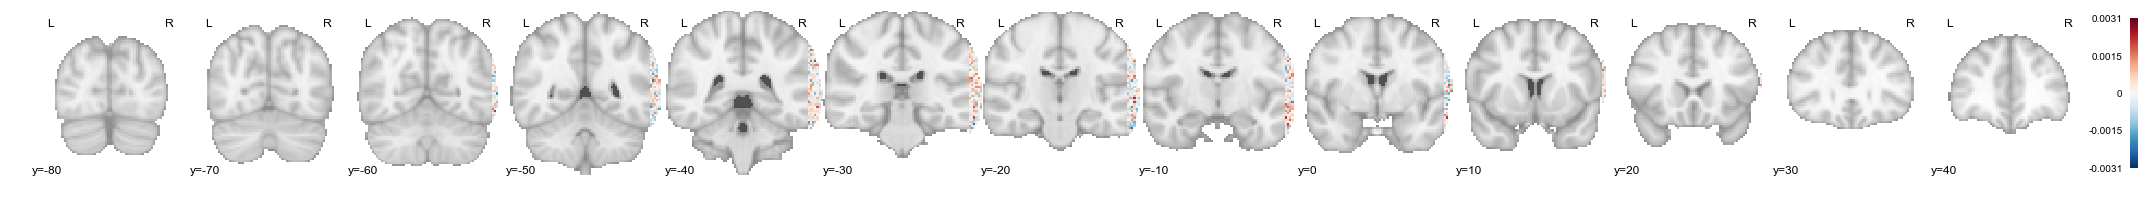

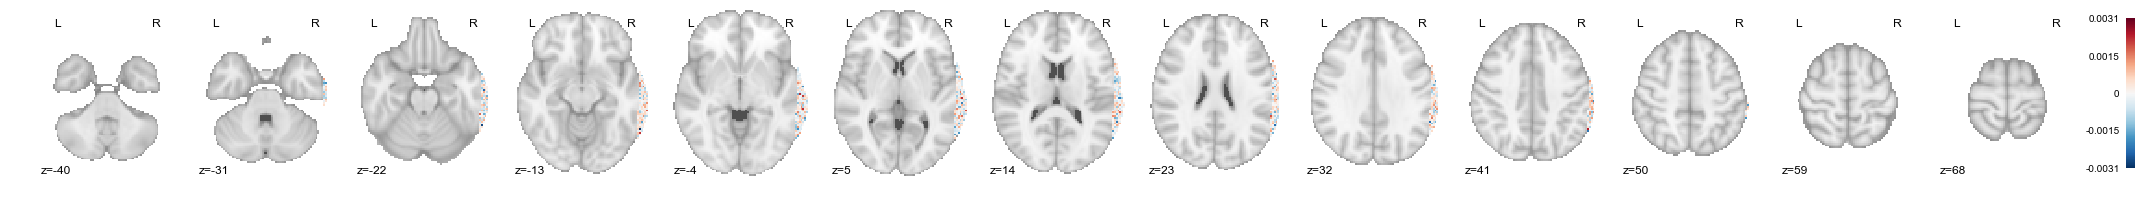

In [24]:
plotBrain(explainer_weight_map)

In [25]:
plt.savefig('threat_LimeExplained.png',bbox_inches='tight')

In [41]:
def explain_the_brain(explainer,brain_data):
    """
    Function that takes the output of an explainer object, i.e. explainer.explain_instance(). And maps it to the brain space
    of the original data.
    
    Args:
        explainer: a Lime explainer explanation object, i.e. the output of explainer.explain_instance()
        brain_data: a nltool.Brain_Data object that contains the original training OR testing data
    
    Returns:
        probability_shift_map: Brain_Data objectshowing amount of probability shift that would occur if that voxel 
                               was not part of the original prediction; also gets plotted
    
    """
    
    from nltools.plotting import plotBrain
    
    vox_explanations = explainer.as_list()
    vox_explanations.columns = ['voxel_id','prob_shift']
    
    if len(brain_data) > 1:
        prob_shift_map = brain_data[0].copy()
    else:
        prob_shift_map = brain_data.copy()
    
    prob_shift_map.data =  np.zeros_like(dat[0].data)
    prob_shift_map.data[vox_explanations['voxel_id']] = vox_explanations['prob_shift']
    
    plotBrain(prob_shift_map)
    
    return prob_shift_map